In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func'

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind = engine) 
conn = engine.connect()
station_data = pd.read_sql("SELECT * FROM station", conn)
measurement_data = pd.read_sql("SELECT * FROM measurement", conn)


In [9]:
station_data

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [10]:
measurement_data

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
lastDate = measurement_data["date"].max()
measurement_data.loc[measurement_data["date"] == lastDate]

,id,station,date,prcp,tobs
2723,2724,USC00519397,2017-08-23,0.00,81.0
7634,7635,USC00514830,2017-08-23,0.00,82.0
12186,12187,USC00519523,2017-08-23,0.08,82.0
19549,19550,USC00516128,2017-08-23,0.45,76.0


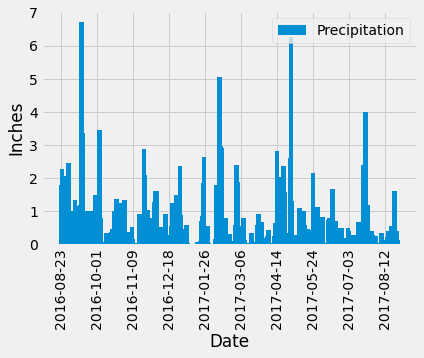

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
fil1 = Measurement.date <= lastDate
# Calculate the date one year from the last date in data set.
dateList = list(lastDate)
dateList[3] = '6'
lastYear = "".join(dateList)
fil2 = Measurement.date >= lastYear

# Perform a query to retrieve the data and precipitation scores
measureQuery = session.query(Measurement).\
        filter(fil1 & fil2)

# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.read_sql(measureQuery.statement, conn).set_index("date")

# Sort the dataframe by date
measurement_df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
plt.bar(measurement_df.index, measurement_df['prcp'].values, align = 'center', width = 5, label = 'Precipitation')
plt.xticks(np.arange(0, 365, 39), rotation = 90)
plt.yticks(np.arange(0, 8, 1))
# fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend()
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df = measurement_df['prcp'].agg(['mean', 'median', 'var', 'std', 'sem'])
prcp_df

mean      0.177279
median    0.020000
var       0.212696
std       0.461190
sem       0.010259
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
stationQuery = session.query(Station).count()
stationQuery

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
activeQuery = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc())
activeQuery.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
stationId = activeQuery.first()[0]
lowTemp = round(measurement_data.loc[measurement_data['station'] == stationId]['tobs'].min())
highTemp = round(measurement_data.loc[measurement_data['station'] == stationId]['tobs'].max())
avgTemp = round(measurement_data.loc[measurement_data['station'] == stationId]['tobs'].mean())
print(f'Lowest Temp: {lowTemp}')
print(f'Highest Temp: {highTemp}')
print(f'Average Temp: {avgTemp}')

Lowest Temp: 54
Highest Temp: 85
Average Temp: 72


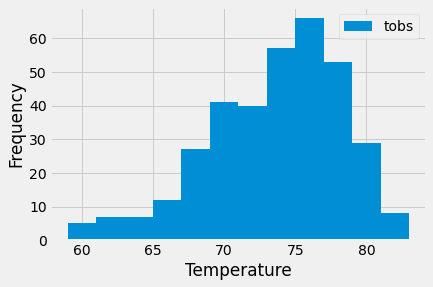

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempQuery = session.query(Measurement.tobs).\
            filter(Measurement.station == stationId).\
            filter(fil1 & fil2).\
            order_by(Measurement.tobs)

#Plot
temps = []

for temp in tempQuery.all():
    curTemp = round(temp[0])
    temps.append(curTemp)
    
plt.hist(temps, bins = 12, label = 'tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# Close session

In [18]:
# Close Session
session.close()